<a href="https://colab.research.google.com/gist/proppy/26525ff7d9810247759a8d3ff3c41dcb/openlane-with-conda-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenLane flow with conda-eda packages

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

## Install conda

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://repo.anaconda.com/miniconda/Miniconda3-py37_4.11.0-Linux-x86_64.sh")
!sed -i -e /cudatoolkit/d /usr/local/conda-meta/pinned

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py37_4.11.0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


## Install dependencies

In [2]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - magic
  - openroad
  - netgen
  - yosys
  - gdstk
  - tcllib
  - python
  - pip
  - pip:
    - pyyaml
    - click
    - pandas

Writing environment.yml


In [3]:
!conda env update --prefix /usr/local --file environment.yml

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

## Get OpenLane

In [1]:
!git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane
# fix for https://github.com/The-OpenROAD-Project/OpenLane/issues/1037
!curl -L -O https://patch-diff.githubusercontent.com/raw/The-OpenROAD-Project/OpenLane/pull/1044.patch
!patch -d OpenLane -p1 < 1044.patch

Cloning into 'OpenLane'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 482 (delta 107), reused 222 (delta 42), pack-reused 0
Receiving objects: 100% (482/482), 1.56 MiB | 24.26 MiB/s, done.
Resolving deltas: 100% (107/107), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1496    0  1496    0     0   6769      0 --:--:-- --:--:-- --:--:--  6769
patching file scripts/tcl_commands/floorplan.tcl


## Write verilog

In [2]:
%%writefile inverter.v
module inverter(input wire in, output wire out);
    assign out = !in;
endmodule

Writing inverter.v


## Write configuration

In [3]:
%%writefile config.tcl

set ::env(DESIGN_NAME) inverter

set script_dir [file dirname [file normalize [info script]]]
set ::env(VERILOG_FILES) "$script_dir/inverter.v"

set ::env(CLOCK_TREE_SYNTH) 0
set ::env(CLOCK_PORT) ""

set ::env(PL_RANDOM_GLB_PLACEMENT) 1

set ::env(FP_SIZING) absolute
set ::env(DIE_AREA) "0 0 50 50"
set ::env(PL_TARGET_DENSITY) 0.80


set ::env(FP_PDN_HORIZONTAL_HALO) 6
set ::env(FP_PDN_VERTICAL_HALO) 6

set ::env(DIODE_INSERTION_STRATEGY) 3

# disable version checks because we use conda packaged versions
set ::env(TEST_MISMATCHES) none
# disable klayout because of https://github.com/hdl/conda-eda/issues/175
set ::env(RUN_KLAYOUT) 0
# disable CVC because of https://github.com/hdl/conda-eda/issues/174
set ::env(RUN_CVC) 0

Writing config.tcl


## Run OpenLane Flow

- disable CVC because of https://github.com/hdl/conda-eda/issues/174
- disable klayout because of https://github.com/hdl/conda-eda/issues/175

In [4]:
import os
PATH=os.environ['PATH']
%env PDK_ROOT=/usr/local/share/pdk
%env TCLLIBPATH=/usr/local/lib/tcllib1.20
%env OPENLANE_ROOT=/content/OpenLane
%env PATH={PATH}:/content/OpenLane:/content/OpenLane/scripts
%env OPENLANE_LOCAL_INSTALL=1
!flow.tcl -design .

env: PDK_ROOT=/usr/local/share/pdk
env: TCLLIBPATH=/usr/local/lib/tcllib1.20
env: OPENLANE_ROOT=/content/OpenLane
env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/OpenLane:/content/OpenLane/scripts
env: OPENLANE_LOCAL_INSTALL=1
OpenLane 7891c2c8859e8c800226920c181fa039ad298e79
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using design configuration at /content/config.tcl
[INFO]: Sourcing Configurations from /content/config.tcl
[INFO]: PDKs root directory: /usr/local/share/pdk
[INFO]: PDK: sky130A
[INFO]: Setting PDKPATH to /usr/local/share/pdk/sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library is set to: sky130_fd_sc_hd
[INFO]: Sourcing Configurations from /content/config.tcl
[INFO]: Current r

## Display layout

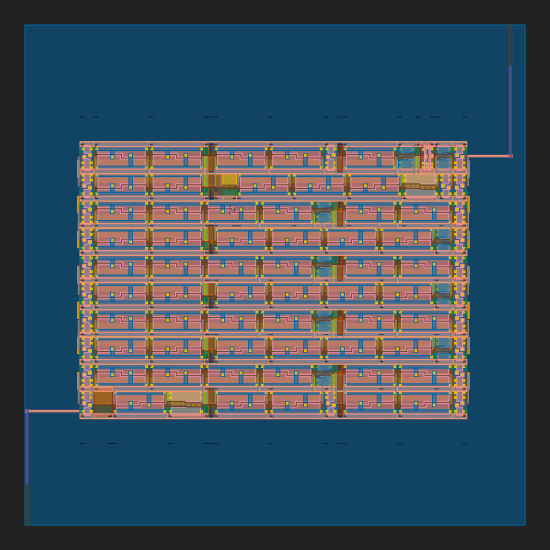

In [5]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('/content/runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('inverter.svg')
IPython.display.SVG('inverter.svg')

## Dump flow report

In [7]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
final_summary_reports = sorted(pathlib.Path('/content/runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
df.transpose()

,0
Unnamed: 0,0
design,/content
design_name,inverter
config,RUN_2022.04.12_15.36.14
flow_status,flow completed
total_runtime,0h0m29s0ms
routed_runtime,0h0m18s0ms
(Cell/mm^2)/Core_Util,-2.0
DIEAREA_mm^2,0.0025
CellPer_mm^2,-1
